## G10. 더 멋진 번역기 만들기

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

### Step 1. 데이터 다운로드

In [3]:
path_to_dir = os.getenv('HOME') +'/aiffel/s2s_translation'
path_to_file_ko = path_to_dir +'/korean-english-park.train.ko'
path_to_file_en = path_to_dir +'/korean-english-park.train.en'

In [4]:
with open(path_to_file_ko, "r") as f:
    raw_ko = f.read().splitlines()
    
print("Data Size: ", len(raw_ko))
print("Example: ")

for sen in raw_ko[0:100][::20]:
    print(">>", sen)

Data Size:  94123
Example: 
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
with open(path_to_file_en, "r") as f:
    raw_en = f.read().splitlines()
    
print("Data Size: ", len(raw_en))
print("Example: ")

for sen in raw_en[0:100][::20]:
    print(">>", sen)

Data Size:  94123
Example: 
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


### Step 2. 데이터 정제 및 토큰화

In [6]:
raw = zip(raw_ko, raw_en)

In [7]:
cleaned_corpus = set(raw)

In [8]:
len(cleaned_corpus)

78968

In [9]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    #한글 포함
    sentence = re.sub(r"[^a-zA-Z|0-9|ㄱ-하-ㅣ가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()
        
    return sentence


In [10]:
corpus_list = list(cleaned_corpus)

In [11]:
corpus_list[100]

("소말리아해적 퇴치용 '음향대..", 'and Pax Jolie-Pitt, 4, is fourth on the list.')

In [12]:
kor_corpus = []
eng_corpus = []


num_examples = len(corpus_list)

for pair in corpus_list[:num_examples]:
    ret_ko = preprocess_sentence(pair[0])
    ret_en = preprocess_sentence(pair[1], s_token=True, e_token=True)
    if len(ret_ko) <= num_examples:
        kor_corpus.append(ret_ko)
        eng_corpus.append(ret_en)

print(len(kor_corpus))
print(len(eng_corpus))
print("Korean:", kor_corpus[100])   
print("English:", eng_corpus[100])

78968
78968
Korean: 소말리아해적 퇴치용 음향대 . .
English: and pax jolie-pitt , 4 , is fourth on the list .


In [13]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang,
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write('{}\n'.format(row))

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

In [14]:
VOCAB_SIZE = 7000
ko_tokenizer = generate_tokenizer(kor_corpus, VOCAB_SIZE, lang="ko")
en_tokenizer = generate_tokenizer(eng_corpus, VOCAB_SIZE, lang="en")


In [15]:
en_tokenizer.set_encode_extra_options('bos:eos')

True

In [16]:
source = []
target = []

for i in range(0, len(kor_corpus)):
    ko_token = ko_tokenizer.encode_as_ids(kor_corpus[i])
    en_token = en_tokenizer.encode_as_ids(eng_corpus[i])
    
    if len(ko_token) > 50: continue
    if len(en_token) > 50: continue
    
    source.append(ko_token)
    target.append(en_token)

In [17]:
len(source)

63668

In [18]:
enc_train = tf.keras.preprocessing.sequence.pad_sequences(source, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(target, padding='post')

print(enc_train.shape)
print(dec_train.shape)

(63668, 50)
(63668, 50)


### Step 3. 훈련하기

In [19]:
 #mask, transformer, decoder 

In [20]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [22]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [24]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [25]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [26]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [27]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        if shared_emb:
            self.enc_emb = self.dec_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [41]:
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.3
vocab_size = 7000

transformer = Transformer(n_layers=n_layers,
                         d_model=d_model,
                         n_heads=n_heads,
                         d_ff=d_ff,
                         dropout=dropout,
                         src_vocab_size=vocab_size,
                         tgt_vocab_size=vocab_size,
                         pos_len=200,
                         shared_fc=True,
                         shared_emb=True)

In [42]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [44]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [45]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [46]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [47]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [48]:
import numpy as np
import tensorflow as tf

def generate_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

#def generate_causality_mask(src_len, tgt_len):
#    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
#    return tf.cast(mask, tf.float32)

#def generate_masks(src, tgt):
#    enc_mask = generate_padding_mask(src)
#    dec_mask = generate_padding_mask(tgt)

#    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
#    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

#    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
#    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

#    return enc_mask, dec_enc_mask, dec_mask

In [49]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [50]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [51]:
import random
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    print('Translations' )
    for sentence in sentences:
        translate(sentence, transformer, ko_tokenizer, en_tokenizer)
    print()
    print('Hyperparameters' )
    print('n_layers :', n_layers)
    print('d_model :', d_model)
    print('n_heads : ', n_heads)
    print('d_ff :', d_ff)
    print('dropout :', dropout)
    print()
    print('TRAINING')
    print('Warmup Steps: 4000')
    print('Batch size : 64')
    print('Epoch At : ', epoch+1)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama s obama is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are also said .
Input: 커피는 필요 없다.
Predicted translation: i think you have been .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: they are based to been killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  1



Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is reported .
Input: 커피는 필요 없다.
Predicted translation: it s not sure that it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the deadly attacked by the dead and a deadly wounded .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  2



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is the latest .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is the latest in the city of the city .
Input: 커피는 필요 없다.
Predicted translation: it s not just .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen deaths were killed by the dead .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  3



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama has been elected .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s home
Input: 커피는 필요 없다.
Predicted translation: it s a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll at least seven deaths .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  4



Translations
Input: 오바마는 대통령이다.
Predicted translation: president barack obama has the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are in the city .
Input: 커피는 필요 없다.
Predicted translation: it s not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  5



Translations
Input: 오바마는 대통령이다.
Predicted translation: the president is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens .
Input: 커피는 필요 없다.
Predicted translation: there are coffee coffee coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven childrens were among the dead .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  6



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are staying in towns for their towns .
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: some victims were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  7



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama has a nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city population is also the town of sanmination .
Input: 커피는 필요 없다.
Predicted translation: it doesn t need a humanitarian need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  8



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is working for the people .
Input: 커피는 필요 없다.
Predicted translation: must take a need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven victims were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  9



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is a bardaio .
Input: 시민들은 도시 속에 산다.
Predicted translation: people stay in their homes .
Input: 커피는 필요 없다.
Predicted translation: don t need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: officials said there were far few deaths .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  10



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is the president for oval .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are over for their years .
Input: 커피는 필요 없다.
Predicted translation: don t need humanitarian needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were responding to the death toll .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  11



Translations
Input: 오바마는 대통령이다.
Predicted translation: president obama has a holder .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is dagened in sectarian g .
Input: 커피는 필요 없다.
Predicted translation: it was unifiedtable .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed in the barry .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  12



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is in the town .
Input: 커피는 필요 없다.
Predicted translation: don t need humans .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven others were later killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  13



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama takes his own .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens aren t mixture
Input: 커피는 필요 없다.
Predicted translation: don t need at a rate .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  14



Translations
Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the democratic party .
Input: 시민들은 도시 속에 산다.
Predicted translation: locals generals buy a fastest .
Input: 커피는 필요 없다.
Predicted translation: there shouldn t need a human avoid .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  15


Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .
Encoder Layer 1


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


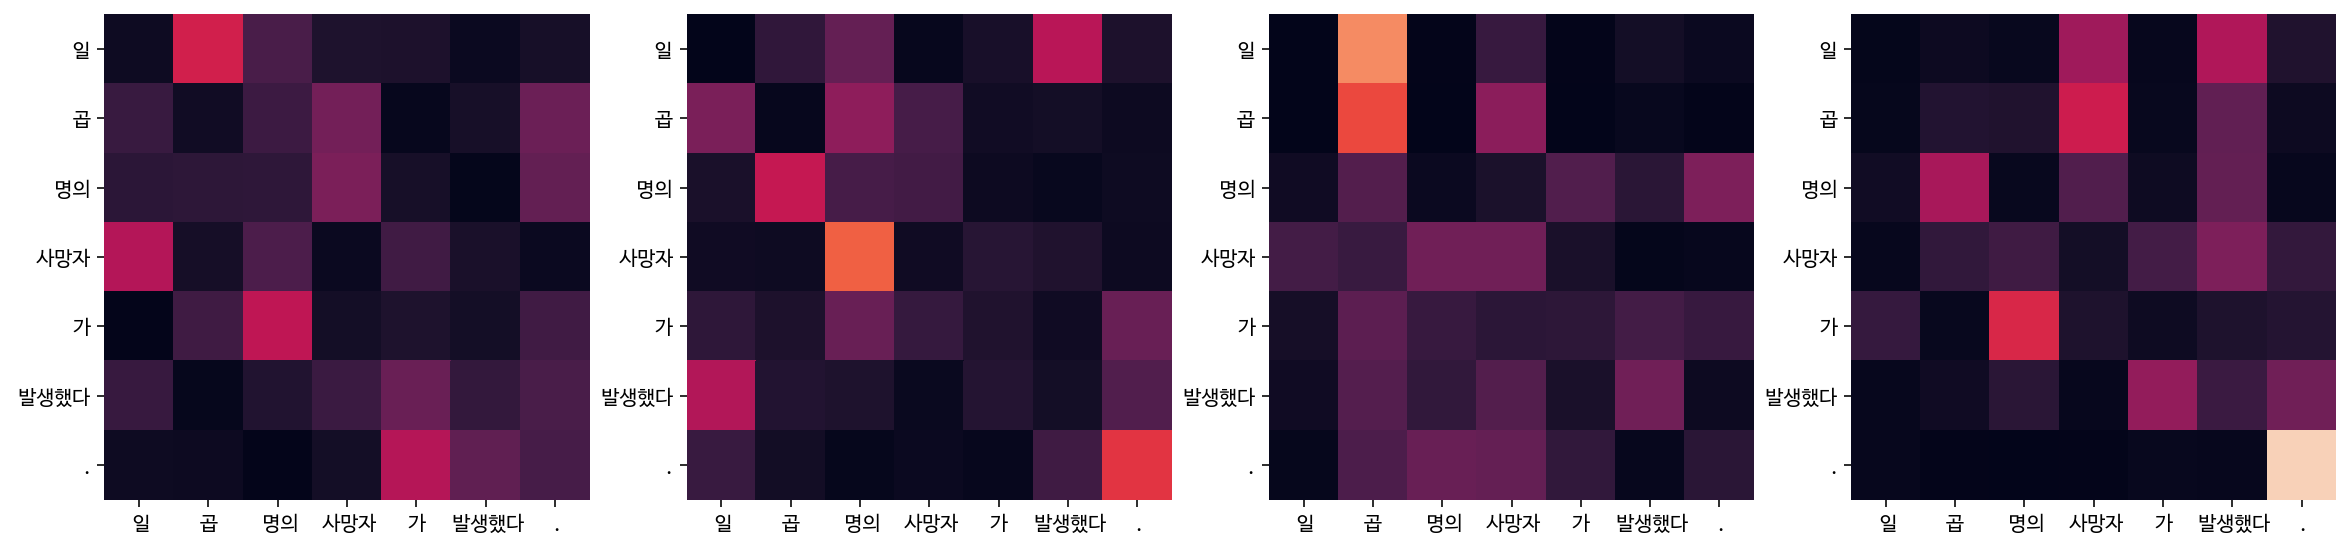

Encoder Layer 2


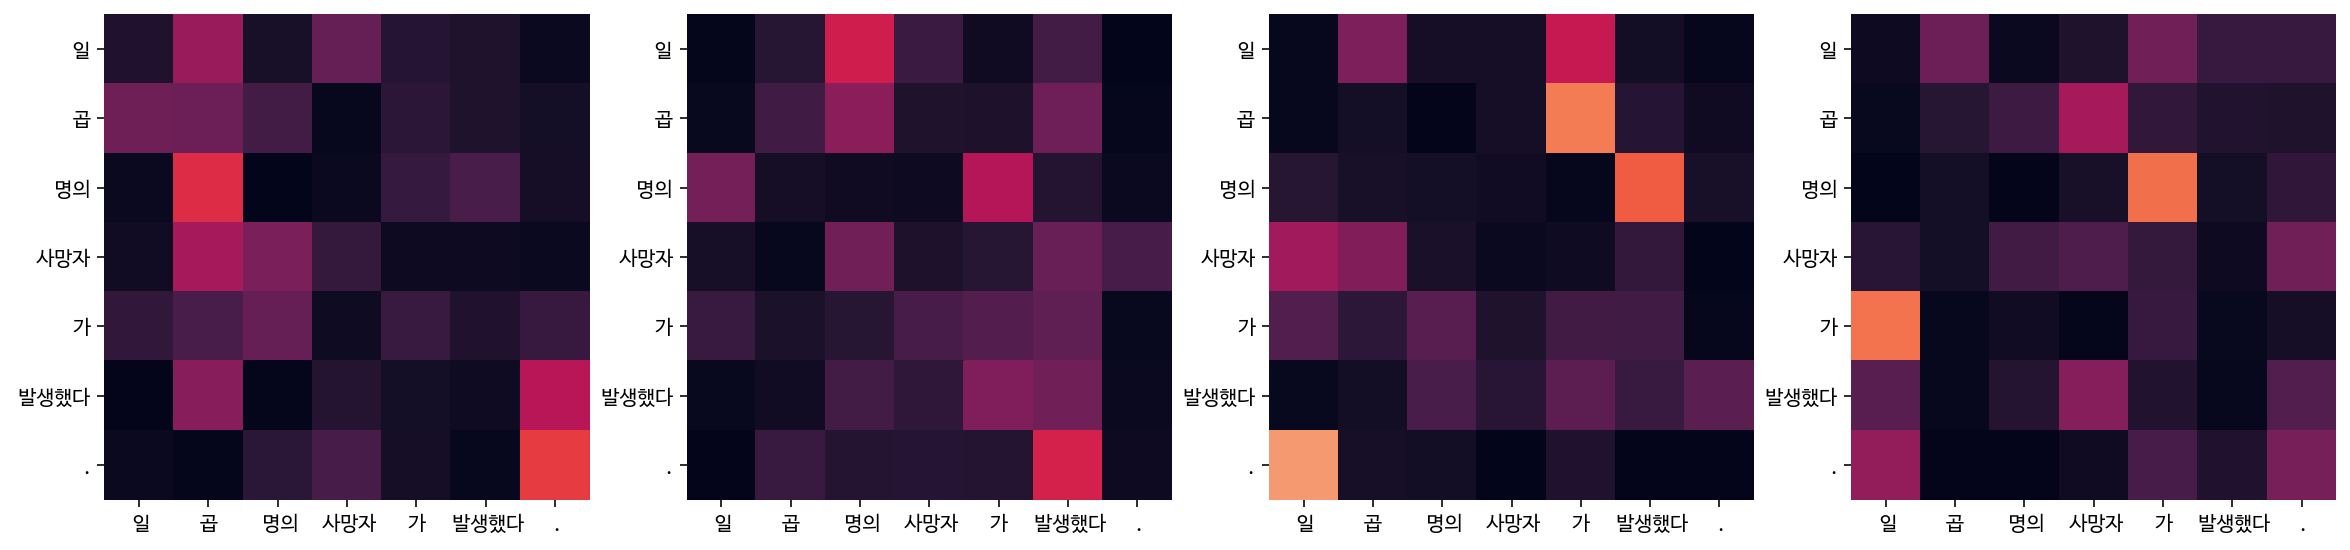

Decoder Self Layer 1


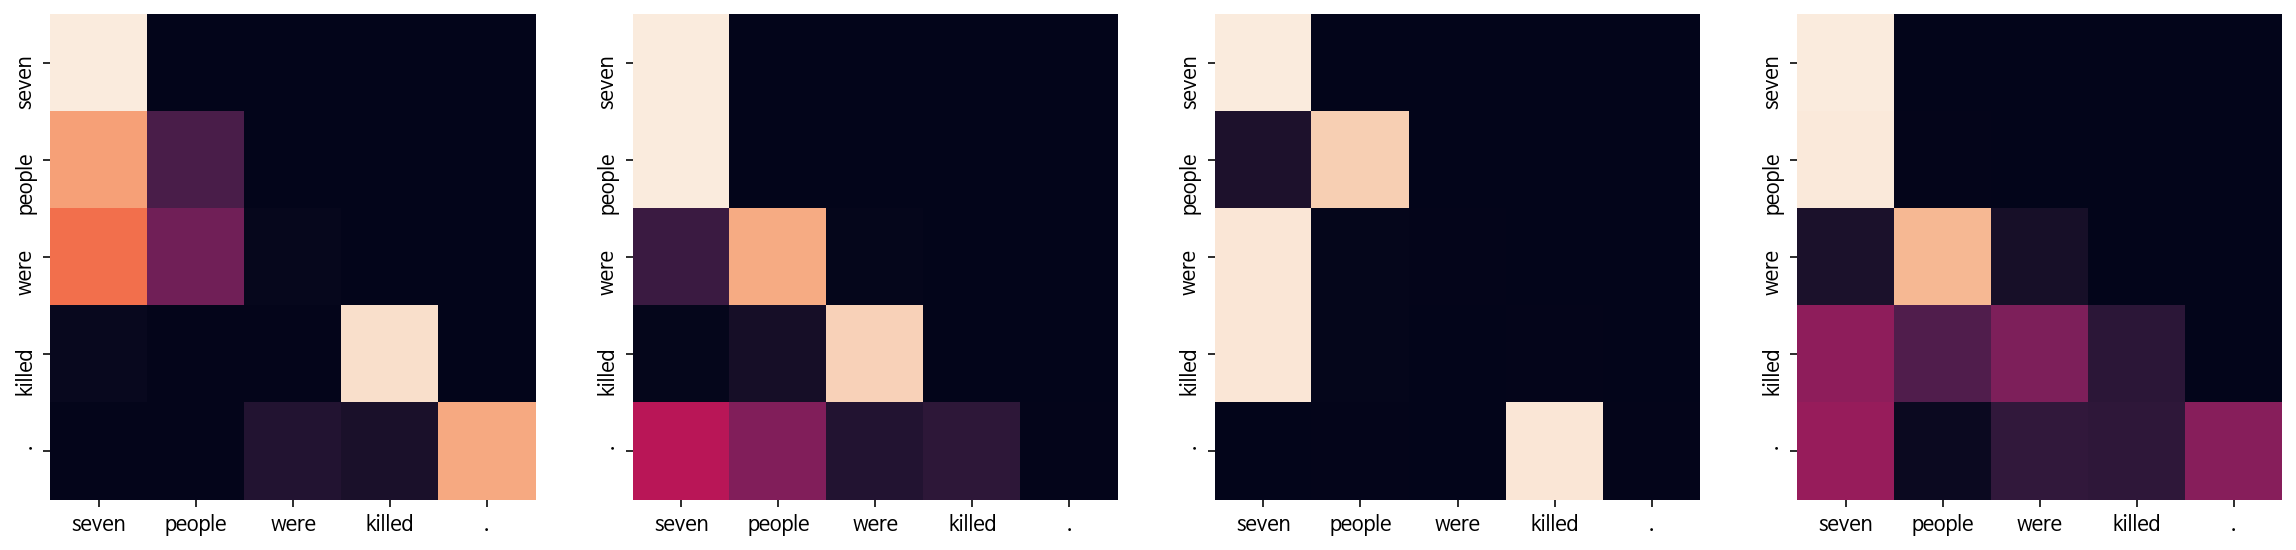

Decoder Src Layer 1


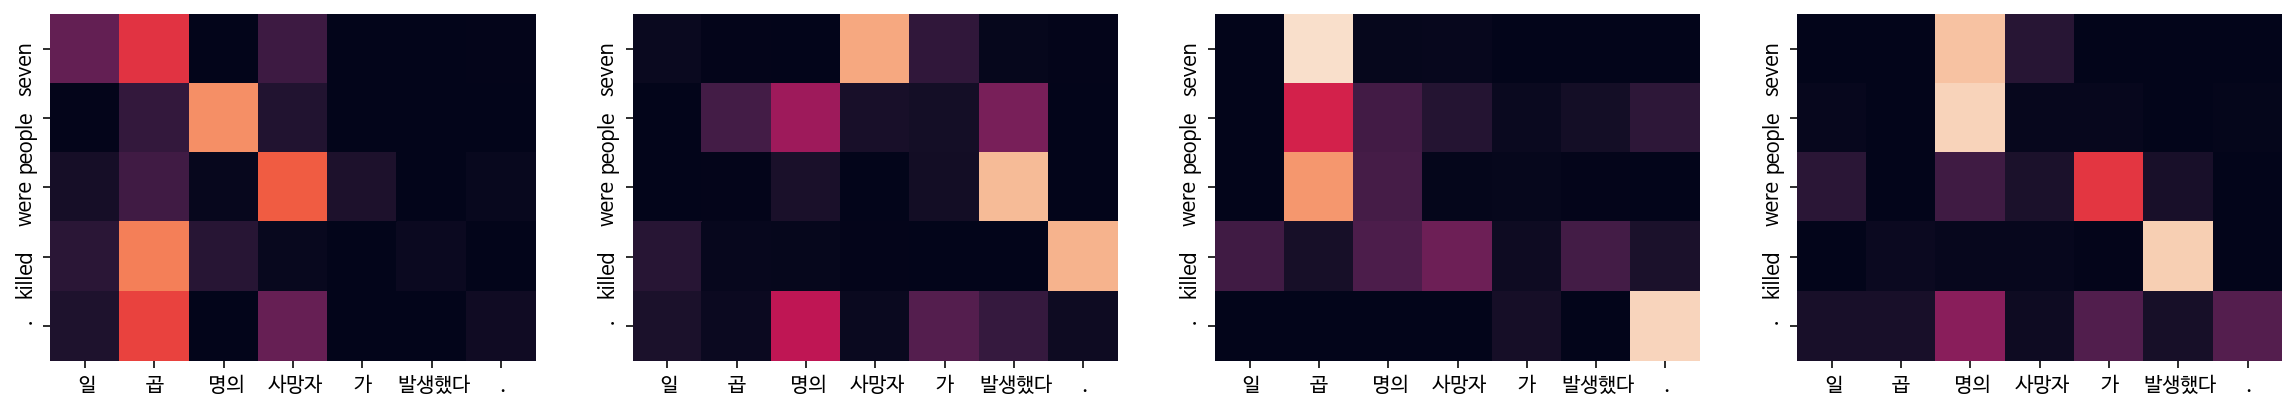

Decoder Self Layer 2


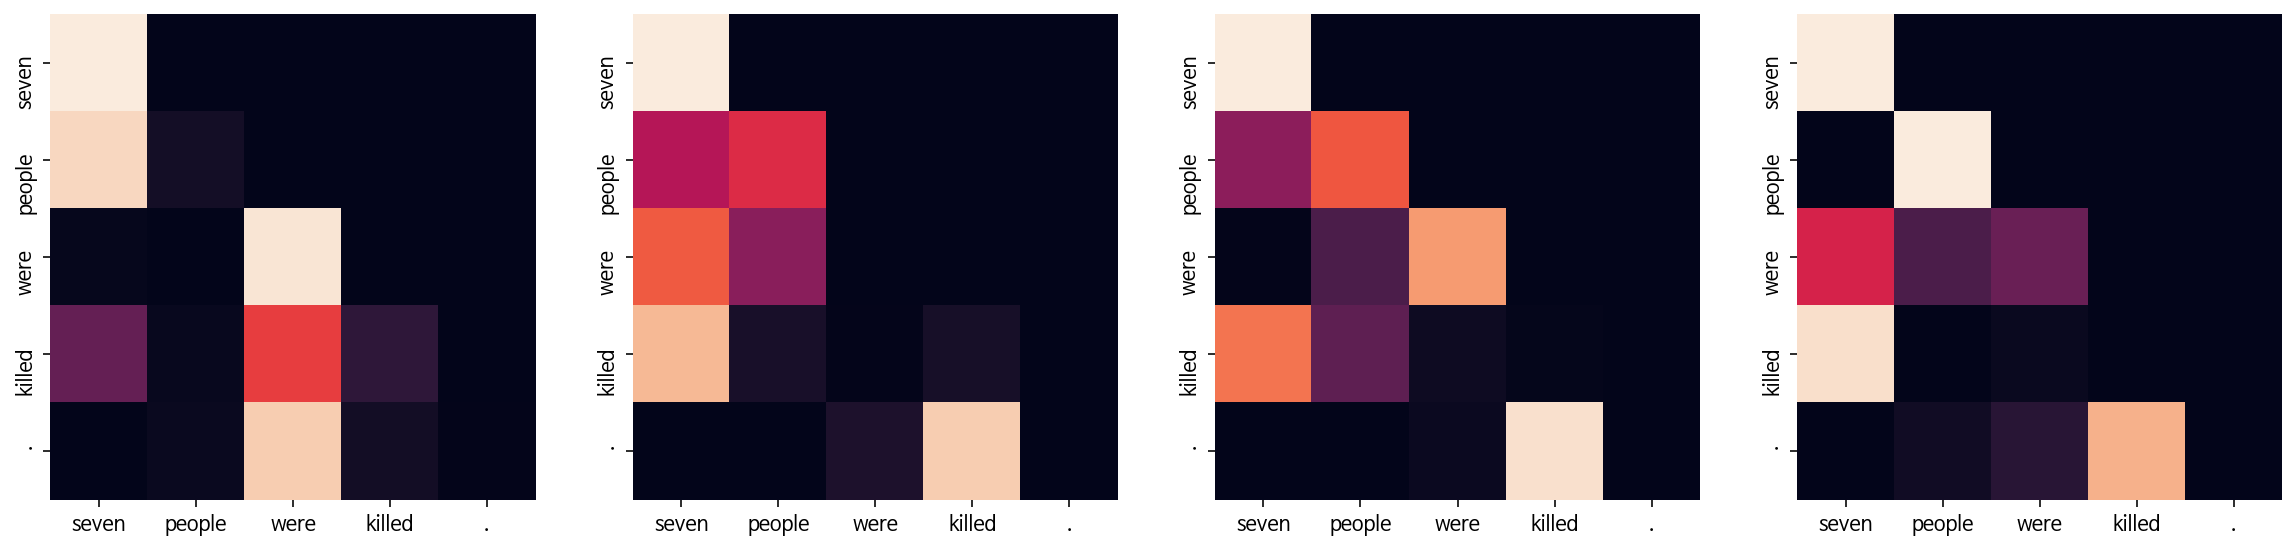

Decoder Src Layer 2


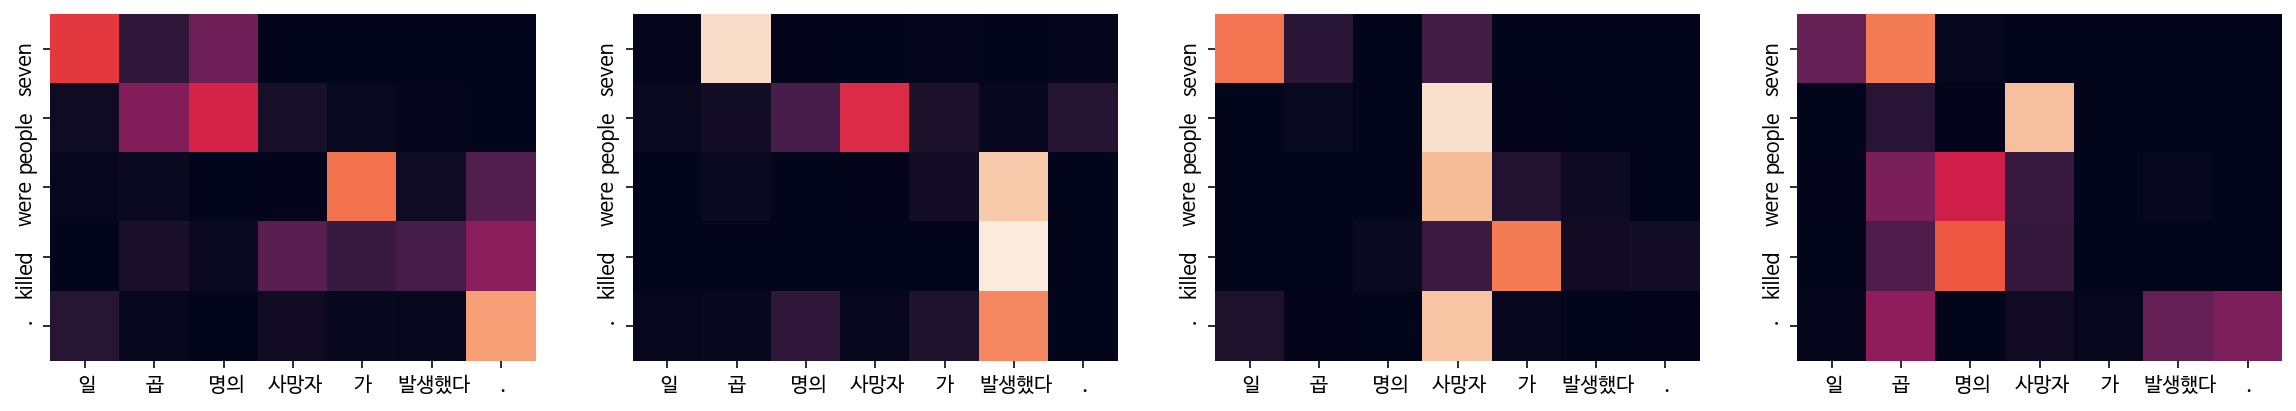

In [52]:
translate('일곱 명의 사망자가 발생했다.',transformer, ko_tokenizer, en_tokenizer, plot_attention = True)

- 데이터정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행됨
- Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상동작함
- 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침함
- 단어장 크기의 경우 최초 20000으로 설정하였으나, 아래와 같은 에러가 발생하여 7000으로 줄여 진행함 (이것이 번역 품질에 영향을 미쳤을 가능성 있어 보임)

RuntimeError: Internal: /sentencepiece/src/trainer_interface.cc(590) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (20000). Please set it to a value <= 11394.
RuntimeError: Internal: /sentencepiece/src/trainer_interface.cc(590) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (11000). Please set it to a value <= 7547.
